## Hier werden alle ML-Verfahren in einem Tool ausprobiert um diese in einer Tabelle gegenüberstellen zu können

In [1]:
# General tools
import os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# To save the models
from joblib import dump, load

# For transformations and predictions
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# For Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# For scoring
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics

# For validation
from sklearn.model_selection import train_test_split as train_test_split

# Wichtig um den Graphen zu Plotten
from sklearn import tree

# package used to calculate Shap values
import shap 

In [2]:
def Data_import(Datensatz):
    base_dir = Path.cwd()
    if Datensatz == 'Raw':
        filename = Path('data.csv')
    elif Datensatz == 'Cleaned':
        #path = 'data_cleaned.csv'
        filename = Path('data_cleaned.csv')
    else: 
        print('Kein Datensatz ausgewählt. Datensatz:',Datsatz)
    path = os.path.join(base_dir, filename)
    return pd.read_csv(path)

In [3]:
def Data_preprossesing(df, Optimierung):
    """
    Diese Funktion erhält einen DF und soll diesen in den Test_Train_split durchführen 
    und ggf. Frac bei großen Aufgaben
    """
    np.random.seed(10)
    remove_n = 0
    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    # Hier wurden die Jahre in Dekaden umgewandelt. Das Ergebniss war allerdings schlechter, als die normalen Jahre
    #df['Dekade']= df['year']%100
    #df = df.drop('year', axis=1)
    df = df.drop(drop_indices)
    if Optimierung == "Keine":
        X = df.drop(['popularity','artists', 'id','name','release_date'], axis=1)
    elif Optimierung == "Jahr_gedroppt":
        X = df.drop(['popularity','artists', 'id','name','release_date','year'], axis=1)
    else:
        X = df.drop(['popularity','artists', 'id','name','release_date'], axis=1)
    y = df['popularity']
    return train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
def Lineare_Regression(X_train, y_train):
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    return regressor.predict(X_test).clip(0,100), Lineare_Regression.__name__ , regressor

In [5]:
def KNN(X_train, y_train):
    RMSE1_train, RMSE1_test = [], []  
    for i in range(5,101,5):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_train,y_train)
        y_train_pred = knn.predict(X_train)
        knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
        RMSE1_train.append(knn_train_rmse.round(3))
        y_test_pred = knn.predict(X_test)
        knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
        RMSE1_test.append(knn_test_rmse.round(3))
    return knn.predict(X_test).clip(0,100),KNN.__name__ ,knn

In [6]:
def Decision_Tree(X_train, y_train):
    tree = DecisionTreeRegressor(max_leaf_nodes=41, min_samples_split=2000)
     
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train).clip(0, 100)
    train_rmse = np.sqrt(mse(y_train, y_train_pred))
    y_test_pred = tree.predict(X_test).clip(0, 100)
    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    return tree.predict(X_test).clip(0, 100), Decision_Tree.__name__, tree

In [7]:
def Decision_Tree_grid(X_train, y_train):
    tree = DecisionTreeRegressor(max_leaf_nodes=None, min_samples_split=20)
    param_grid =  {'max_depth': np.arange(9, 15),                   
                   "min_samples_leaf": np.arange(40, 100),
                  }
    tree = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, n_jobs=-1)
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train).clip(0, 100)
    train_rmse = np.sqrt(mse(y_train, y_train_pred))
    y_test_pred = tree.predict(X_test).clip(0, 100)
    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    return tree.predict(X_test).clip(0, 100), Decision_Tree_grid.__name__, tree

In [8]:
def Random_Forest(X_train, y_train):   
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    return clf.predict(X_test), Random_Forest.__name__ , clf

In [9]:
def XGBoost(X_train, y_train):
    xgb_regressor = XGBRegressor(n_estimators=100, max_depth=200, learning_rate=0.01)
    xgb_regressor.fit(X_train, y_train)
    return xgb_regressor.predict(X_test), XGBoost.__name__, xgb_regressor

In [10]:
def Scoring(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE =  metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return MAE, MSE, RMSE

In [11]:
def shap_values(model, X_test):
    explainer = shap.TreeExplainer(model)
    return explainer, explainer.shap_values(X_test)

In [23]:
# Muss nicht verwendet werden, aber speichert die jeweiligen Modelle für die SHAP Analyse
def save_model(str_Verfahren, Datensatz, Optimierung, y_pred, y_test):
    base_dir = Path.cwd()
    filename = Path(str_Verfahren+ '_' + Datensatz+ '_' + Optimierung + '.joblib')
    path = os.path.join(base_dir, filename)
    dump(model,path)
    
    series_y_pred = pd.Series(y_pred)
    df_y_pred = pd.DataFrame(series_y_pred)
    df_y_pred.columns = ["y_pred"]

    df_y_test = pd.DataFrame(y_test)
    df_y_test.columns = ["y_test"]
    df_y_test.reset_index(drop=True, inplace=True)
    merged_df = df_y_pred.merge(df_y_test, left_index=True, right_index=True)
    filename = Path('y_pred_'+str_Verfahren+ '_' + Datensatz+ '_' + Optimierung + '.xlsx')
    path = os.path.join(base_dir, filename)
    merged_df.to_excel(path)
    return print(str_Verfahren + ' mit Datensatz ' + Datensatz+ ' und Optimierung ' + Optimierung +" erfolgreich gespeichert")

### Diese Funktion lässt alle ML-Verfahren durchlaufen:
#### In func werden alle durchiteriert, dauert aber ca 40 min für alle auf meinem System (Ryzen 5 3600, 16GB RAM)

In [12]:
list_Algorithmen = [Decision_Tree_grid] #, KNN, Decision_Tree,Decision_Tree_grid ,Random_Forest, XGBoost

list_Datensatz = ["Raw"] #'Raw'

list_Optimierung = ["Keine", "Jahr_gedroppt"]

Scoring_Table = pd.DataFrame({'Verfahren': [],
                                  'Optimierung':[],
                                  'Datensatz': [],
                                  'MAE': [],
                                  'MSE': [],
                                  'RMSE': []})

for Datensatz in list_Datensatz:
    df = Data_import(Datensatz)
    for Optimierung in list_Optimierung:
        X_train, X_test, y_train, y_test = Data_preprossesing(df, Optimierung)
        for Algorithmen in list_Algorithmen:
            y_pred, str_Verfahren, model = Algorithmen(X_train, y_train) 
            #save_model(str_Verfahren, Datensatz, Optimierung, y_pred, y_test)
            MAE, MSE, RMSE = Scoring(y_test, y_pred)
            Scoring_Table = Scoring_Table.append({'Verfahren': str_Verfahren,
                                                  'Optimierung':Optimierung,                                                 
                                                  'Datensatz': Datensatz,
                                                  'MAE': MAE,
                                                  'MSE': MSE,
                                                  'RMSE': RMSE}, ignore_index=True)

Scoring_Table.drop_duplicates(inplace=True)
Scoring_Table.transpose()

,0,1
Verfahren,Decision_Tree_grid,Decision_Tree_grid
Optimierung,Keine,Jahr_gedroppt
Datensatz,Raw,Raw
MAE,8.77835,12.6096
MSE,180.851,282.959
RMSE,13.4481,16.8214


In [37]:
#Nur wenn Grid Search verwendet wurde
print(model.best_score_)
print(model.best_params_)
print(model.best_estimator_)

0.6008248741768588


In [ ]:
# Nur wenn Decision Tree verwendet wurde
print(model.get_depth())

In [ ]:
# Speichert die Ergebnistabelle
Scoring_Table.transpose().to_excel('Ergebniss_Tabelle.xlsx')

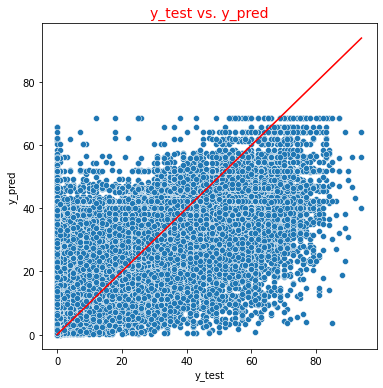

In [18]:
# Mit dieser Grafik kann man sich die geplotten Ergebnisse einzelner Modelle anzeigen lassen.
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')
ax.set_title('y_test vs. y_pred', fontsize=14, color='red')
fig.savefig(r'C:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Seminararbeit Spotify Mining\Abbildungen\Vorhersage.pdf')
plt.show()

###### X_test

In [105]:
# Dient zu Feature Importance analyse
print('Feature importances:')
for i, col in enumerate(X_train.columns):
  print(f'{col:12}: {model.feature_importances_[i]:.3f}')

Feature importances:
acousticness: 0.614
danceability: 0.019
duration_ms : 0.046
energy      : 0.013
explicit    : 0.056
instrumentalness: 0.118
key         : 0.000
liveness    : 0.016
loudness    : 0.056
mode        : 0.000
speechiness : 0.022
tempo       : 0.011
valence     : 0.028


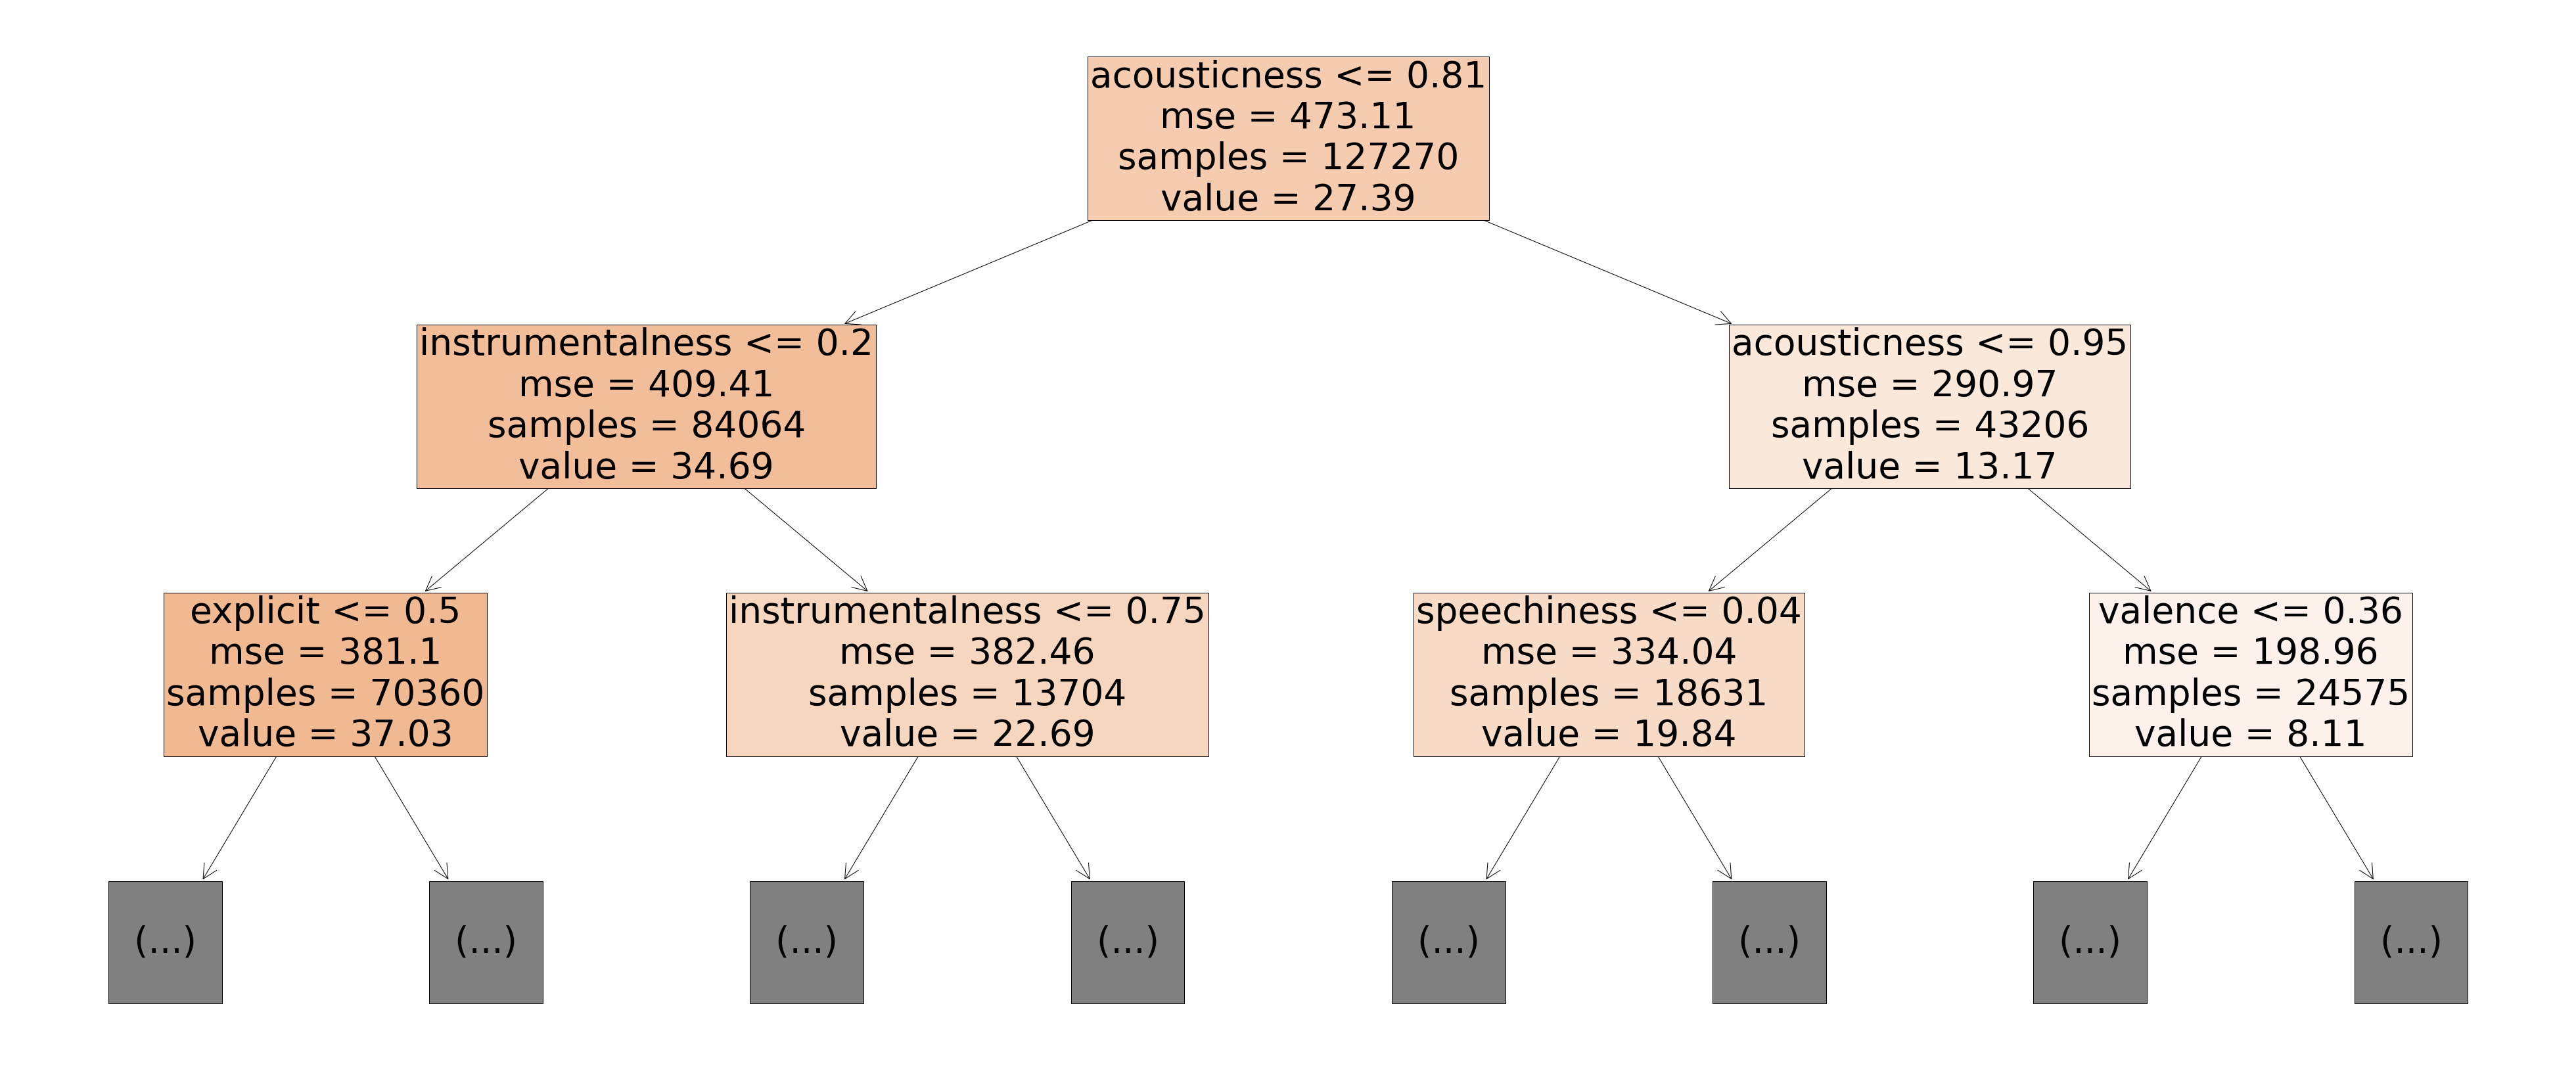

In [133]:
# Speichert den Decision Tree als PDF
features_names = X_train.columns
plt.subplots(figsize=(70, 30))
tree.plot_tree(model, max_depth=2,feature_names = features_names, filled=True,precision=2,fontsize=55) 
plt.savefig('Decision_tree_grafisch_Jahr_gedroppt.pdf')